In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import random
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

import warnings
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path
import pandas as pd

root = Path("./dataset")   # your dataset folder

# get each class name (folder name)
classes = sorted([p.name for p in root.iterdir() if p.is_dir()])

# count images in each class folder
counts = {c: len(list((root / c).glob("*.*"))) for c in classes}

# create a dataframe
df_counts = (
    pd.DataFrame.from_dict(counts, orient="index", columns=["count"])
      .sort_values("count", ascending=False)
)

print(df_counts)


           count
rime        1160
fogsmog      851
dew          698
sandstorm    692
glaze        639
snow         621
hail         591
rain         526
frost        475
lightning    377
rainbow      232


In [8]:
dim1 = []    # width
dim2 = []    # height
colors = []  # color channel
weather = [] # category

path = './dataset'

# loop through each subfolder (category)
for folder_name in os.listdir(path):
    subfolder_path = os.path.join(path, folder_name)
    
    # skip if not a directory
    if not os.path.isdir(subfolder_path):
        continue

    for image_file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_file)
        image = imread(image_path)
        
        # handle grayscale images
        if len(image.shape) < 3:
            image = image.reshape(image.shape + (1,))
        
        height, width, channel = image.shape
        dim1.append(width)      # width on x-axis
        dim2.append(height)     # height on y-axis
        colors.append(channel)
        weather.append(folder_name)  # use folder name as label

# create DataFrame
df = pd.DataFrame({
    'width': dim1,
    'height': dim2,
    'channels': colors,
    'weather': weather
})

In [11]:
np.mean(dim1)


520.0297289419995

In [12]:
np.mean(dim2)

373.8417371028855

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# Transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # baseline small size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# -------------------------
# Load dataset
# -------------------------
dataset = datasets.ImageFolder('./dataset', transform=transform)
num_classes = len(dataset.classes)
print("Classes:", dataset.classes)

# -------------------------
# Train/Validation split : simple 80/20 split!
# -------------------------
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# -------------------------
# Define simple CNN
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # after 2 pool layers
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes).to(device)

# -------------------------
# Loss & optimizer
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# Training loop
# -------------------------
epochs = 5  # baseline, short
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# -------------------------
# Validation
# -------------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Validation Accuracy: {:.2f}%".format(100 * correct / total))


Using device: cpu
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Epoch 1/5, Loss: 1.3830
Epoch 2/5, Loss: 0.9803
Epoch 3/5, Loss: 0.8276
Epoch 4/5, Loss: 0.7261
Epoch 5/5, Loss: 0.6015
Validation Accuracy: 71.60%


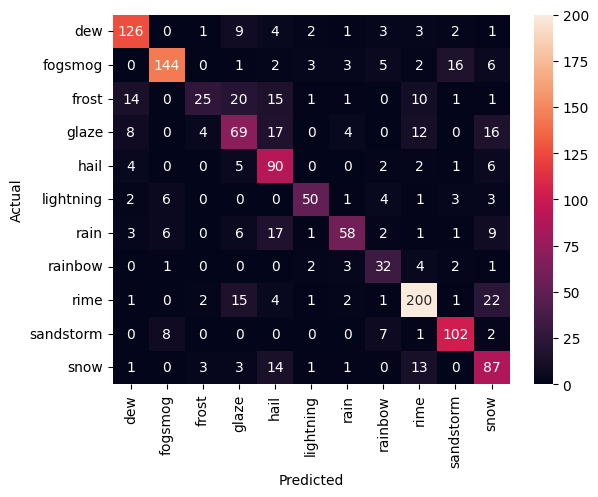

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
